In [1]:
import os

In [2]:
os.chdir('../')
%pwd

'/home/paladin/Downloads/Facial_Impression_Recognition_Calassification'

In [3]:
from dataclasses import dataclass
from pathlib import Path

@dataclass(frozen=True)
class TrainingConfig:
    root_dir: Path
    trained_model_path: Path
    updated_base_model_path: Path
    training_data: Path
    validation_data: Path
    params_epochs: int
    params_batch_size: int
    params_is_augmentation: bool
    params_imgage_size: list

@dataclass(frozen=True)
class PrepareCallbacksConfig:
    root_dir: Path
    tensorboard_root_log_dir: Path
    ckeckpoint_model_filepath: Path

In [4]:
from cnnClassifier.constants import *
from cnnClassifier.utils import read_yaml, create_directories

2023-07-27 18:22:36.053802: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-07-27 18:22:36.115329: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-07-27 18:22:36.116102: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-27 18:22:37.179689: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [5]:
class configurationManeger:
    def __init__(self, 
                 config_filepath = CONFIG_FILE_PATH,
                 secret_filepath = SECRET_FILE_PATH,                 
                 params_filepath = PARAMS_FILE_PATH):
        
        self.config = read_yaml(config_filepath) 
        self.secret = read_yaml(secret_filepath)        
        self.params = read_yaml(params_filepath)

        create_directories([self.config.artifacts_root])   
    
    def get_prepare_callbacks_config(self) -> PrepareCallbacksConfig:
        config = self.config.prepare_callbacks
        model_ckpt_dir = os.path.dirname(config.ckeckpoint_model_filepath)

        create_directories([config.tensorboard_root_log_dir, model_ckpt_dir ])

        prepare_callbacks_config = PrepareCallbacksConfig(
           root_dir= config.root_dir,
           tensorboard_root_log_dir= config.tensorboard_root_log_dir,
           ckeckpoint_model_filepath=  config.ckeckpoint_model_filepath
        )

        return prepare_callbacks_config 
    
    def get_training_config(self) -> TrainingConfig:
        config= self.config.training
        training_data_dir = os.path.dirname(self.config.data_transformation.local_train_angry_dir)
        validation_data_dir = os.path.dirname(self.config.data_transformation.local_val_angry_dir)
        
        create_directories([config.root_dir])

        training_config = TrainingConfig(
        root_dir= config.root_dir,
        trained_model_path= config.trained_model_path, 
        updated_base_model_path= self.config.prepare_base_model.updated_model_path, 
        training_data= training_data_dir,
        validation_data= validation_data_dir, 
        params_epochs= self.params.EPOCHS, 
        params_batch_size= self.params.BATCH_SIZE, 
        params_is_augmentation= self.params.AUGMENTATION,
        params_imgage_size= self.params.IMAGE_SIZE
        )

        return training_config

In [6]:
from cnnClassifier.utils import load_object, save_object, model_loss
import keras

In [7]:

class Training:
    def __init__(self, config: TrainingConfig):
        self.config = config

    def get_base_model(self):
        self.model = load_object(path= self.config.updated_base_model_path, h5=True)

    def train_valid_generator(self):

        datagenerator_kwargs = dict(
            rescale= 1./255
            # if there was no validation set:
            # validation_split = 0.20
        )

        dataflow_kwargs = dict(
            target_size=self.config.params_imgage_size[:-1],
            batch_size = self.config.params_batch_size,
            interpolation= 'bilinear'
        )
        ## NOTE: Keras generator alway looks for subfolders (representing the classes). Images insight the subfolders are associated with a class.
        if self.config.params_is_augmentation:
            datagenerator = keras.preprocessing.image.ImageDataGenerator(
                rotation_range=20,
                horizontal_flip=True,
                width_shift_range=0.2,
                height_shift_range=0.2,
                shear_range=0.2,
                zoom_range=0.2,
                **datagenerator_kwargs
            )

        else:
            datagenerator = keras.preprocessing.image.ImageDataGenerator(
                **datagenerator_kwargs
            )
        ## NOTE: subdet is added when we use validation_split, where directory for both training and validation is the same.
        ## NOTE: shuffle= False for validation as we want to check the performance model using predict_generator 
        self.valid_generator = datagenerator.flow_from_directory(
            directory= self.config.validation_data,
            #subset= "validation",
            shuffle= False,            
            **dataflow_kwargs
            )
        
        self.train_generator = datagenerator.flow_from_directory(
            directory= self.config.training_data,
            #subset= "training",
            shuffle= True,           
            **dataflow_kwargs
            )
        
    def train(self, callback_list: list):
        self.steps_per_epoch = self.train_generator.samples // self.train_generator.batch_size
        self.validation_steps = self.valid_generator.samples // self.valid_generator.batch_size

        history = self.model.fit(
            self.train_generator,
            validation_data = self.valid_generator,
            epochs= self.config.params_epochs,
            steps_per_epoch= self.steps_per_epoch,
            validation_steps=self.validation_steps,
            callbacks = callback_list
            )
        
        model_loss(history)
        filenames = self.valid_generator.filenames
        nb_samples = len(filenames)
        predict = self.model.predict_generator(self.valid_generator, steps = nb_samples)
        print(predict)

        save_object(path= self.config.trained_model_path, obj=self.model, h5=True)    
        


In [8]:
import sys
from cnnClassifier.exception import CustomException
from cnnClassifier.components.prepare_callbacks import PrepareCallbacks 

Found 3589 images belonging to 7 classes.
Found 28709 images belonging to 7 classes.
112/112 [==============================] - ETA: 0s - loss: 1.8648 - accuracy: 0.2144

/home/paladin/Downloads/Facial_Impression_Recognition_Calassification/venv/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


112/112 [==============================] - 320s 3s/step - loss: 1.8648 - accuracy: 0.2144 - val_loss: 1.8128 - val_accuracy: 0.2363


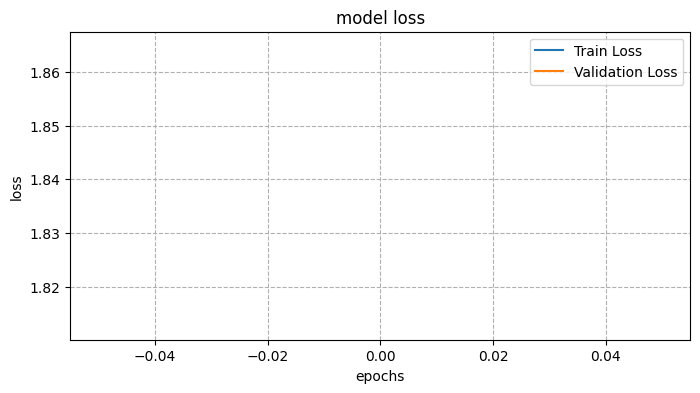

/tmp/ipykernel_23212/2098462863.py:69: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  predict = self.model.predict_generator(self.valid_generator, steps = nb_samples)


[[0.16557409 0.01135406 0.18413661 ... 0.26437005 0.07315167 0.15244402]
 [0.08139113 0.01346778 0.14317548 ... 0.25152963 0.13013148 0.12112436]
 [0.20518455 0.00811287 0.16577603 ... 0.19259058 0.12843427 0.09691856]
 ...
 [0.10110669 0.02261812 0.23283367 ... 0.1189701  0.12399362 0.17315586]
 [0.07442158 0.03363118 0.1651511  ... 0.1467446  0.07243331 0.11343342]
 [0.20161714 0.00672147 0.22872661 ... 0.12264541 0.12481391 0.06903777]]


/home/paladin/Downloads/Facial_Impression_Recognition_Calassification/src/cnnClassifier/utils.py:126: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  save_model(obj, path)


In [9]:
try:
    config = configurationManeger()
    prepare_callbacks_config = config.get_prepare_callbacks_config()
    prepare_callbacks = PrepareCallbacks(config=prepare_callbacks_config)
    callback_list = prepare_callbacks.get_tb_ckpt_callbacks()

    training_config = config.get_training_config()
    training = Training(config= training_config)
    training.get_base_model()
    training.train_valid_generator()
    training.train(callback_list= callback_list)

except Exception as e:
    raise CustomException(e, sys)

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, accuracy_score, classification_report, confusion_matrix, precision_recall_fscore_support



def evaluation_metrics(y_test, y_pred):
    precision = np.min(precision_score(y_test, y_pred, average=None))
    recall = np.min(recall_score(y_test, y_pred, average=None))
    accuracy = accuracy_score(y_test, y_pred)
    return precision, recall, accuracy
    
def pandas_classification_report(y_true, y_pred, classes):
    
    """
    This function returns scikit learn output metrics.classification_report 
    into CSV/tab-delimited format
    :param y_true: the actual value of y
    :param y_pred: the predicted valuye of y
    :param classes: list of label classes to be predicted
    """
    metrics_summary = precision_recall_fscore_support(y_true=y_true, y_pred=y_pred)    
    avg = list(precision_recall_fscore_support(y_true=y_true, y_pred=y_pred, average='weighted'))
    metrics_sum_index = ['precision', 'recall', 'f1-score', 'support']
    class_report_df = pd.DataFrame(list(metrics_summary),index=metrics_sum_index)

    support = class_report_df.loc['support']
    total = support.sum() 
    avg[-1] = total

    class_report_df['avg / total'] = avg              
    df = class_report_df.T
    df.index = classes + ['avg / total']
    return df

def plot_confusion_matrix(y_true, y_pred, classes,
                            normalize=False,
                            title=None,
                            cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    Borrowed from the scikit-learn library documentation
    :param y_true: the actual value of y
    :param y_pred: the predicted valuye of y
    :param classes: list of label classes to be predicted
    :param normalize: normalize the data
    :param title: title of the plot for confusion matrix
    :param cmap: color of plot        
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    #classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
            
    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
            yticks=np.arange(cm.shape[0]),
            # ... and label them with the respective list entries
            xticklabels=classes, yticklabels=classes,
            title=title,
            ylabel='True label',
            xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
                rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return plt, fig, ax 

In [11]:
model_loss(history)

NameError: name 'history' is not defined